
## Background and notes:
"Electricity demand patterns matter for valuing electricity supply resources" http://www.eia.gov/todayinenergy/detail.cfm?id=12711

"Case study of daily electricity demand in New England" (shows hourly curve): http://www.eia.gov/todayinenergy/detail.cfm?id=830

hourly_jan01 = requests.get("https://webservices.iso-ne.com/api/v1.1/combinedhourlydemand/day/20140101/location/4008.json", auth=('travisknop@gmail.com', 'Nirvana1'))

Hourly day electricity demand: http://www.iso-ne.com/isoexpress/web/reports/load-and-demand/-/tree/demand-by-zone

NOAA data: http://www7.ncdc.noaa.gov/CDO/cdoselect.cmd

Nat gas pipelines: http://www.eia.gov/pub/oil_gas/natural_gas/analysis_publications/ngpipeline/northeast.html


### Common ISO-NE Abbrevs

drtp = demand response threshhold price

lmp = Locational Marginal Pricing

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Weather Data~~~~~~~~

In [90]:
boston_weather = pd.read_csv("~/travis_python/homework/FINAL/FINAL/boston_weather_2014.csv", header=1)
boston_weather = boston_weather[boston_weather.high != 'high']
boston_weather["date"] = pd.DatetimeIndex(start='1/1/2014', periods=365, freq='d')
boston_weather.drop('Jan', axis=1, inplace=True)
boston_weather["high"] = boston_weather["high"].apply(int)
boston_weather["avg"] = boston_weather["avg"].apply(int)
boston_weather["low"] = boston_weather["low"].apply(int)

In [91]:
def to_fahrenheit(temp):
    return (temp * (9 / 5) + 32).round(1)

boston_weather["high"] = boston_weather['high'].apply(to_fahrenheit)
boston_weather["avg"] = boston_weather['avg'].apply(to_fahrenheit)
boston_weather["low"] = boston_weather['low'].apply(to_fahrenheit)

In [92]:
boston_weather.set_index("date")

,high,avg,low
date,,,
2014-01-01,28.4,24.8,19.4
2014-01-02,26.6,14.0,1.4
2014-01-03,14.0,8.6,1.4
2014-01-04,26.6,15.8,1.4
2014-01-05,37.4,30.2,24.8
2014-01-06,55.4,42.8,28.4
2014-01-07,28.4,19.4,8.6
2014-01-08,21.2,15.8,6.8
2014-01-09,30.2,24.8,19.4


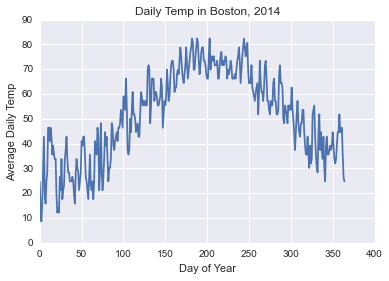

In [93]:
plt.plot(boston_weather.avg)
plt.ylabel("Average Daily Temp")
plt.xlabel("Day of Year")
plt.title("Daily Temp in Boston, 2014")
plt.show()

## Daily Climate Aves ~~~~~~~~~~~~

In [94]:
daily_climate = pd.read_csv("~/travis_python/homework/FINAL/FINAL/dailyclimate.csv", header=1)

In [95]:
daily_climate["MaxT"] = daily_climate["MaxT"].apply(float)
daily_climate["AveT"] = daily_climate["AveT"].apply(float)
daily_climate["MinT"] = daily_climate["MinT"].apply(float)


In [96]:
daily_climate.head(3)

,Mo Dy,MaxT,AveT,MinT
0,1/ 1,37.8,30.7,23.6
1,1/ 2,37.6,30.5,23.4
2,1/ 3,37.5,30.4,23.3


In [97]:
boston_weather["high_climate"] = daily_climate.MaxT
boston_weather["ave_climate"] = daily_climate.AveT
boston_weather["low_climate"] = daily_climate.MinT
boston_weather["avg_deviation"] = boston_weather.avg - boston_weather.ave_climate
boston_weather.tail()

,high,avg,low,date,high_climate,ave_climate,low_climate,avg_deviation
371,51.8,44.6,37.4,2014-12-27,NaN,NaN,NaN,NaN
372,51.8,46.4,39.2,2014-12-28,NaN,NaN,NaN,NaN
373,41.0,35.6,30.2,2014-12-29,NaN,NaN,NaN,NaN
374,30.2,26.6,21.2,2014-12-30,NaN,NaN,NaN,NaN
375,30.2,24.8,19.4,2014-12-31,NaN,NaN,NaN,NaN


Why is this step dropping 10 lines of data????

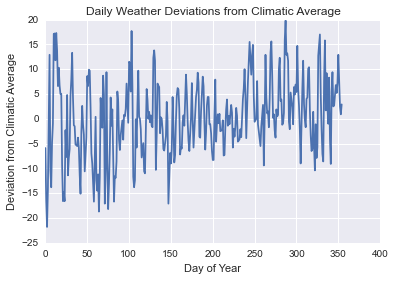

In [98]:
plt.plot(boston_weather.avg_deviation)
plt.ylabel("Deviation from Climatic Average")
plt.xlabel("Day of Year")
plt.title("Daily Weather Deviations from Climatic Average")
plt.show()

In [99]:
boston_weather.to_csv("weat_clim_dev_missing_data.csv")

# Energy Data

In [100]:
"""demand2014a = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140101_20140214.csv", header=6)
demand2014b = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140215_20140331.csv", header=6)
demand2014c = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140401_20140515.csv", header=6)
demand2014d = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140516_20140629.csv", header=6)
demand2014e = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140630_20140813.csv", header=6)
demand2014f = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140814_20140927.csv", header=6)
demand2014g = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140928_20141110.csv", header=6)
demand2014h = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20141111_20141225.csv", header=6)
demand2014i = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20141226_20150208.csv", header=6)
df1 = [demand2014a, demand2014b, demand2014c, demand2014d, demand2014e, demand2014f, demand2014g, demand2014h, demand2014i]

hourlydemand14 = pd.concat(df1)

hourlydemand14.head(3)"""

'demand2014a = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140101_20140214.csv", header=6)\ndemand2014b = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140215_20140331.csv", header=6)\ndemand2014c = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140401_20140515.csv", header=6)\ndemand2014d = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140516_20140629.csv", header=6)\ndemand2014e = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140630_20140813.csv", header=6)\ndemand2014f = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140814_20140927.csv", header=6)\ndemand2014g = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20140928_20141110.csv", header=6)\ndemand2014h = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20141111_20141225.csv", header=6)\ndemand2014i = pd.read_csv("~/downloads/OI_darthrmwh_iso_4006_20141226_20150208.csv", header=6)\ndf1 = [demand2014a, demand2014b, demand2014c, demand2014d, demand2014e, demand2014f, demand2014g, demand2014h, demand2014i]\n\nhourlyde

In [101]:
hourlydemand14 = pd.read_csv("~/travis_python/homework/FINAL/FINAL/Hr_Elec_2011_2015.csv")
hourlydemand14.head()

,Unnamed: 0,date,hour,MWHp,MWH
0,0,2011-01-01,1,1333.2,1438.0
1,1,2011-01-01,2,1255.4,1348.0
2,2,2011-01-01,3,1205.7,1285.7
3,3,2011-01-01,4,1183.3,1252.1
4,4,2011-01-01,5,1195.2,1242.5


<function matplotlib.pyplot.show>

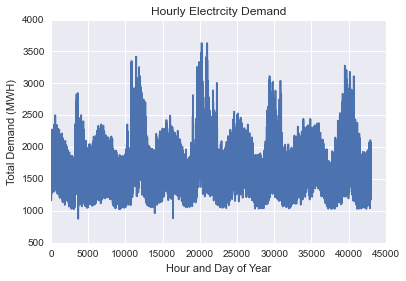

In [102]:
plt.plot(hourlydemand14["MWH"])
plt.xlabel("Hour and Day of Year")
plt.ylabel("Total Demand (MWH)")
plt.title("Hourly Electrcity Demand")
plt.show

In [63]:
hourlydemand14.groupby("date")

In [104]:
hourlydemand_total = hourlydemand14.groupby("date")
hourlydemand_total.head()

,Unnamed: 0,date,hour,MWHp,MWH
0,0,2011-01-01,1,1333.2,1438.0
1,1,2011-01-01,2,1255.4,1348.0
2,2,2011-01-01,3,1205.7,1285.7
3,3,2011-01-01,4,1183.3,1252.1
4,4,2011-01-01,5,1195.2,1242.5
24,24,2011-01-02,1,1283.3,1288.6
25,25,2011-01-02,2,1202.9,1212.8
26,26,2011-01-02,3,1162.8,1171.6
27,27,2011-01-02,4,1141.2,1166.1
28,28,2011-01-02,5,1149.1,1169.2


In [64]:
hourlydemand14.set_index("date")
hourlydemand14.head(3)

,Unnamed: 0,date,hour,MWHp,MWH
0,0,2011-01-01,1,1333.2,1438.0
1,1,2011-01-01,2,1255.4,1348.0
2,2,2011-01-01,3,1205.7,1285.7


<function matplotlib.pyplot.show>

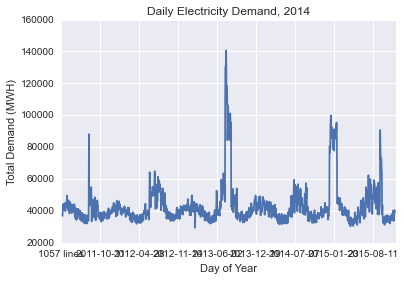

In [65]:
daily_energy = hourlydemand14.groupby("date").aggregate(np.sum)
daily_energy["MWH"].plot()
plt.xlabel("Day of Year")
plt.ylabel("Total Demand (MWH)")
plt.title("Daily Electricity Demand, 2014")
plt.show

In [66]:
boston_weather = boston_weather.set_index("date")

In [67]:
boston_weather.head()

,high,avg,low,high_climate,ave_climate,low_climate,avg_deviation
date,,,,,,,
2014-01-01,28.4,24.8,19.4,37.8,30.7,23.6,-5.9
2014-01-02,26.6,14.0,1.4,37.6,30.5,23.4,-16.5
2014-01-03,14.0,8.6,1.4,37.5,30.4,23.3,-21.8
2014-01-04,26.6,15.8,1.4,37.3,30.2,23.1,-14.4
2014-01-05,37.4,30.2,24.8,37.2,30.1,22.9,0.1


In [68]:
daily_elec = hourlydemand14.set_index("date")

In [83]:
daily_elec2 = daily_elec.reset_index()

In [84]:
daily_elec2["date"] = pd.to_datetime(daily_elec2["date"])

In [85]:
daily_elec2 = daily_elec2.set_index("date")

In [86]:
daily_elec2.head()

,Unnamed: 0,hour,MWHp,MWH
date,,,,
2011-01-01,0,1,1333.2,1438.0
2011-01-01,1,2,1255.4,1348.0
2011-01-01,2,3,1205.7,1285.7
2011-01-01,3,4,1183.3,1252.1
2011-01-01,4,5,1195.2,1242.5


In [87]:
energy = daily_elec2["MWH"]
day_ahead = daily_elec2["MWHp"]

In [70]:
print(boston_weather.head(), "\n", energy.to_frame().head())

            high   avg   low  high_climate  ave_climate  low_climate  \
date                                                                   
2014-01-01  28.4  24.8  19.4          37.8         30.7         23.6   
2014-01-02  26.6  14.0   1.4          37.6         30.5         23.4   
2014-01-03  14.0   8.6   1.4          37.5         30.4         23.3   
2014-01-04  26.6  15.8   1.4          37.3         30.2         23.1   
2014-01-05  37.4  30.2  24.8          37.2         30.1         22.9   

            avg_deviation  
date                       
2014-01-01           -5.9  
2014-01-02          -16.5  
2014-01-03          -21.8  
2014-01-04          -14.4  
2014-01-05            0.1   
                MWH
date              
2011-01-01  1438.0
2011-01-01  1348.0
2011-01-01  1285.7
2011-01-01  1252.1
2011-01-01  1242.5


In [81]:
print(boston_weather.dtypes)

high             float64
avg              float64
low              float64
high_climate     float64
ave_climate      float64
low_climate      float64
avg_deviation    float64
dtype: object


In [88]:
energy2.merge(boston_weather, left_index=True, right_index=True, how="inner")

TypeError: type object argument after * must be a sequence, not map

In [79]:
daily_data = boston_weather.merge(daily_elec["MWH"].to_frame(), 
                                  left_index=True, 
                                  right_index=True, 
                                  how="outer")
daily_data = daily_data.merge(day_ahead.to_frame(), left_index=True, right_index=True, how="outer")
daily_data.head()

TypeError: type object argument after * must be a sequence, not map

In [ ]:
reshaped_daily_data = daily_data.avg.values.reshape((-1, 1))
arrayed_mwh = np.asarray(daily_data["MWH.1"])

In [ ]:
def plot_regression(fn):
    # scatter plot first
    plt.scatter(daily_data.avg, daily_data["MWH.1"])
    xmin, xmax = plt.xlim(xmin=0, xmax = 100)
    xs = np.linspace(xmin, xmax, 100)
    # fn is our (y = mx + b) expression
    plt.ylim(ymax=65000, ymin=30000)
    plt.plot(xs, [fn(x) for x in xs], color="red", linewidth=3)

In [ ]:
model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=False))])
model.fit(reshaped_daily_data, arrayed_mwh)

# The slope and intercept appear to be flipped?
print(model.named_steps['linear'].coef_)
print(model.named_steps['linear'].intercept_)
print('Variance Score: %.2f' % model.score(reshaped_daily_data, arrayed_mwh))

fn = lambda x: model.predict(x)[0]
plot_regression(fn)

In [ ]:
plt.scatter(daily_data.avg_deviation, daily_data["MWH.1"])
plt.title("Demand and Temperature Deviation")
plt.show()

In [ ]:
plt.scatter(daily_data.ave_climate, daily_data["MWH.1"])

In [ ]:
train_data = daily_data[:200]
test_data = daily_data[200:]

In [ ]:
from sklearn import linear_model

# Regressions

In [ ]:
input_data = daily_data[['avg']]
demand_actual = daily_data['MWH.1']

In [ ]:
regr1 = linear_model.LinearRegression()
fit = regr1.fit(input_data, demand_actual)
print(regr1.score(input_data, demand_actual))

In [ ]:
regr1.predict([100])

In [ ]:
model2 = Pipeline([('poly', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression(fit_intercept=False))])
pred2 = model2.fit(reshaped_daily_data, arrayed_mwh)